**Extinction Analysis Notebook**

This notebook performs an analysis of extinction dynamics in a predator-prey system. The primary goal is to determine the proportion of initial conditions that lead to predator extinction under specific parameter settings. The analysis involves:

1. **Random Initialization**:
   - Generating random initial conditions for prey densities (ρ₁ and ρ₂) and predator group densities (γₓ).

2. **Simulation of Dynamics**:
   - Using a bounded initial value problem (IVP) solver to simulate the system dynamics over a fixed number of iterations.

3. **Extinction Criteria**:
   - Defining extinction based on the population falling below a predefined threshold, and using this to classify whether the iterations led to one of the 6 types of extinction equilibria.

   
5. **Parallel Execution**:
   - Leveraging multiprocessing to run simulations in parallel, significantly reducing computation time for large numbers of initial conditions.

6. **Output and Results**:
   - Calculating the proportion of initial conditions that result in predator extinction and documenting the results.

The notebook integrates functions from the `group_w_pop_funs` and `sim_graph_funs` modules to handle system dynamics and random initialization respectively. It is structured for reproducibility and extensibility for further exploration of extinction scenarios under varying parameters.



**Types of Extinction Equilibria**
1.  Only predators extinct.
1. Predators extinct and both prey extinct
1. Predators extinct and big prey, but not small prey, extinct
1. Predators extinct and small prey, but not big prey, extinct
1. Only big prey is extinct
1. Only small prey is extinct

In [2]:
import numpy as np
from multiprocessing import Pool, cpu_count
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from extinction_utils import *#extinction_analysis_multiprocessing

from group_w_pop_funs import full_model, bounded_ivp, get_initial_points  # Ensure this function works with multiprocessing
from sim_graph_funs import update_params
from equilibria_funs import initiate_g_first_x
import matplotlib.pyplot as plt

This is what chat gpt wrote:

In [6]:
if __name__ == "__main__":
    p_upper = 2
    x_max = 5
    scale = 12
    params_base = dict(η1 = 0.2, η2 = 0.6, A1 = 0.6, A2 = 0.5, 
                       β1 = 8, β2 = 1, 
                       H1a = 0, H2a = 0, H1b=1, H2b=1, 
                      α1_of_1=0.05, α2_of_1=0.95, 
                      s1=2, s2=2, α2_fun_type = 'constant',
                      x_max = x_max, d = 10, scale = scale,
                     Tx = .01, pop_process = True)
    
    params = update_params("scale", scale, params_base)
    print(params)
    num_points = 500
    t_f = 1200
    extinction_threshold = 1e-6
    results = extinction_analysis_multiprocessing(
        num_points, t_f, params, extinction_threshold=extinction_threshold, p_upper = p_upper)
    print(results)


{'η1': 0.049999999999999996, 'η2': 0.6, 'A1': 0.6, 'A2': 0.5, 'β1': 12, 'β2': 1, 'H1a': 0.0, 'H2a': 0, 'H1b': 14.399999999999999, 'H2b': 1, 'α1_of_1': 0.05, 'α2_of_1': 0.95, 's1': 2, 's2': 2, 'α2_fun_type': 'constant', 'x_max': 5, 'd': 10, 'scale': 12, 'Tx': 0.01, 'pop_process': True}
{'predator_extinct_both_prey_extinct': 0, 'predator_extinct_big_prey_extinct': 0, 'predator_extinct_small_prey_extinct': 0, 'predator_extinct': 755, 'big_prey_extinct': 0, 'small_prey_extinct': 0, 'no_extinction': 245}


In [5]:
116/500

0.232

In [7]:
245/1000

0.245

In [22]:

init_pts = get_initial_points(num_points, p_upper = p_upper, **params)
g_vectors = init_pts[:,2:]
xvec = np.arange(1,6,1)
p = np.sum(g_vectors*xvec,1)

(array([  5.,   5.,   7.,   6.,  11.,  18.,  35.,  78., 175., 660.]),
 array([1.24463334, 1.32016937, 1.39570539, 1.47124142, 1.54677745,
        1.62231347, 1.6978495 , 1.77338553, 1.84892155, 1.92445758,
        1.9999936 ]),
 <BarContainer object of 10 artists>)

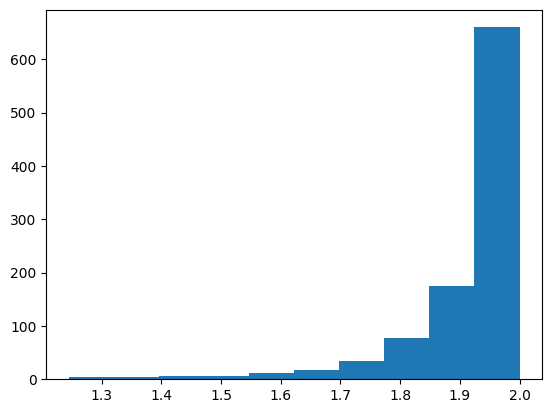

In [25]:
plt.hist(p)

In [17]:
p

array([[0.53079431, 0.99488501, 0.2841496 , 0.09911267, 0.0766164 ],
       [0.50659694, 0.94069141, 0.11044527, 0.17677233, 0.1821229 ],
       [0.55117995, 0.83692212, 0.11684796, 0.43573406, 0.0514645 ],
       ...,
       [0.32096007, 0.81810968, 0.05626987, 0.65342686, 0.14859545],
       [1.07569651, 0.06146414, 0.67411148, 0.11874886, 0.05090913],
       [0.46853972, 0.03096176, 0.10654297, 0.96671358, 0.4087451 ]],
      shape=(1000, 5))

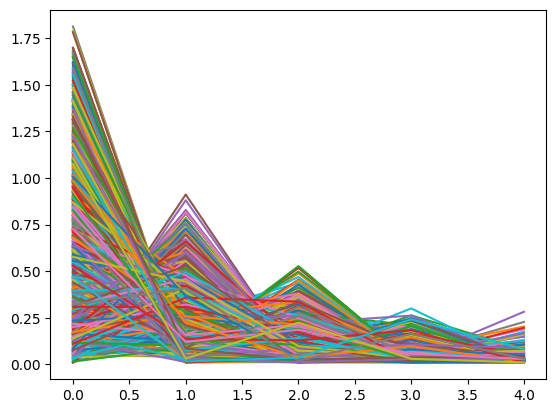

In [15]:
lines = plt.plot(g_vectors.T)

# ChatGPT suggestion for doing this over a whole parameter grid

# Parameter Grid Analysis for Extinction Dynamics

This section performs extinction analysis across a grid of parameter combinations. The goal is to evaluate how different parameter settings influence the extinction dynamics.

### Steps:

1. **Define Parameter Ranges**:
   - Specify the ranges for parameters such as \( \eta_1, \eta_2, A, d, T_x, \text{scale} \).
   - Ensure that constraints like \( \eta_1 < \eta_2 \) and relationships like \( \text{scale} = \frac{H_1}{H_2} = \frac{\beta_1}{\beta_2} \) are maintained.

2. **Generate Parameter Grid**:
   - Use `itertools.product` to generate all possible combinations of parameters.
   - Filter combinations to enforce constraints, e.g., \( \eta_1 < \eta_2 \).

3. **Define Helper Function for Analysis**:
   - The `analyze_params` function takes a single parameter combination as input.
   - Computes extinction proportions using the `extinction_analysis_multiprocessing` function.
   - Returns the parameter combination and extinction results.

4. **Parallelize Computation**:
   - Use Python’s `multiprocessing.Pool` to distribute the analysis across multiple CPU cores.
   - This significantly reduces computation time for large grids.

5. **Save Results**:
   - Store the results as a JSON file for further analysis or visualization.


In [9]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from group_w_pop_funs import bounded_ivp
from sim_graph_funs import get_initial_points

# Define the parameter grid
num_vals = 2#5 # number of values per parameter

eta2_values = np.linspace(0.01, 0.99, num_vals)
A1_values = np.linspace(0.5, 1.5, num_vals)
A2_values = np.linspace(0.5, 1.5, num_vals)
β2_values = np.array([1]) # np.linspace(0.1,2,num_vals)
scale_values = np.linspace(1, 10.0, num_vals)  # Scale (H1/H2 or beta1/beta2)
H2a_values = np.linspace(0,1,num_vals)
H2b_values = np.linspace(0,2,num_vals)
α2_fun_type_vals = ['sigmoid', 'constant']
d_values = np.array([10]) #np.arange(1, 1+num_vals)  # Positive integers
Tx_values = 10**np.linspace(-3, 2, num_vals)  # Positive values


# Fixed parameters
alpha1_of_1 = 0.05
alpha2_of_1 = 0.95
s1, s2 = 2, 2
def check_valid_param_combo(eta2, A1, A2, beta2, scale, H2a, H2b, alpha2_fun_type, d, Tx):
    eta1 = eta2/scale
    bool_growth_rates = eta1 + eta2 < 1
    bool_attack = A1 > A2
    return bool_growth_rates and bool_attack
def analyze_params(params):
    '''
    params is form (η2, A1, A2, β2, scale, H2a, H2b, α2_fun_type, d, Tx)
    '''
    η2, A1, A2, β2, scale, H2a, H2b, α2_fun_type, d, Tx = params
    x_max = 5
    params_base = dict(η1 = 0.2, η2 = η2, A1 = A1, A2 = A2, 
                       β1 = 8, β2 = β2, 
                       H1a = 1, H2a = H2a, H1b=1, H2b=H2b, 
                      α1_of_1=0.05, α2_of_1=0.95, 
                      s1=2, s2=2, α2_fun_type = α2_fun_type,
                      x_max = x_max, d = d,
                     Tx = Tx, scale = scale, pop_process = True)
    
    extinction_params = update_params(param = scale, param_key='scale', 
                                      params_base = params_base)
    

    num_points = 2 #100  # Number of initial conditions
    t_f = 10 # 1000  # Time horizon
    extinction_threshold = 1e-6  # Threshold for extinction

    # Perform extinction analysis
    proportions = extinction_analysis_multiprocessing(
        num_points=num_points,
        t_f=t_f,
        params=extinction_params,
        extinction_threshold=extinction_threshold
    )
    return (params, proportions)

def convert_to_serializable(obj):
    """ Convert NumPy types to Python native types """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    else:
        return obj

# Create the grid of parameters
parameter_grid = []
grid_packed = product(eta2_values, A1_values, A2_values, β2_values,
                      scale_values, H2a_values, H2b_values, 
                      α2_fun_type_vals, d_values, Tx_values )
for param_tuple in grid_packed:
    if check_valid_param_combo(*param_tuple):
        parameter_grid.append(param_tuple)

results = [analyze_params(param_tuple) for param_tuple in parameter_grid]

# save results to a file
import json
with open("extinction_analysis_results.json", "w") as f:
    json.dump(results, f, default=convert_to_serializable)

# if __name__ == "__main__":
#     n_jobs = cpu_count()  # Adjust the number of parallel processes
#     with Pool(processes=n_jobs) as pool:
#         results = pool.map(analyze_params, parameter_grid)

#     # Save results to file
#     import json
#     with open("extinction_analysis_results.json", "w") as f:
#         json.dump(results, f)

# Importing and Analyzing Extinction Analysis Results from JSON

This section describes how to import and work with data from the JSON file generated by the extinction analysis.

### Steps:

1. **Load the JSON File**:
   - Use Python's built-in `json` module to load the data from the file.
   - Convert the JSON format into a Python list for easy manipulation.

2. **Inspect the Data**:
   - Each entry in the list contains:
     - A tuple of parameters (`params`), representing the parameter combination used in the analysis.
     - A dictionary of extinction proportions (`proportions`), showing the fraction of simulations that ended in each type of extinction.

3. **Iterate Through the Results**:
   - Loop through the list to extract and analyze the parameter combinations and extinction proportions.
   - Example analyses include filtering results by specific parameters or calculating summary statistics.




In [10]:
import json

# Load the JSON file
file_path = "extinction_analysis_results.json"  # Replace with your actual file path
with open(file_path, "r") as f:
    data = json.load(f)

# Example: Inspect the first entry
print("First entry in the results:")
print(data[0])

# Example: Iterate through the results
for params, proportions in data:
    print(f"Parameters: {params}")
    print(f"Extinction Proportions: {proportions}")

First entry in the results:
[[0.01, 1.5, 0.5, 1, 1.0, 0.0, 0.0, 'sigmoid', 10, 0.001], {'predator_extinct_both_prey_extinct': 0.0, 'predator_extinct_big_prey_extinct': 0.0, 'predator_extinct_small_prey_extinct': 0.0, 'predator_extinct': 0.0, 'big_prey_extinct': 0.0, 'small_prey_extinct': 0.0, 'no_extinction': 1.0}]
Parameters: [0.01, 1.5, 0.5, 1, 1.0, 0.0, 0.0, 'sigmoid', 10, 0.001]
Extinction Proportions: {'predator_extinct_both_prey_extinct': 0.0, 'predator_extinct_big_prey_extinct': 0.0, 'predator_extinct_small_prey_extinct': 0.0, 'predator_extinct': 0.0, 'big_prey_extinct': 0.0, 'small_prey_extinct': 0.0, 'no_extinction': 1.0}
Parameters: [0.01, 1.5, 0.5, 1, 1.0, 0.0, 0.0, 'sigmoid', 10, 100.0]
Extinction Proportions: {'predator_extinct_both_prey_extinct': 0.0, 'predator_extinct_big_prey_extinct': 0.0, 'predator_extinct_small_prey_extinct': 0.0, 'predator_extinct': 0.0, 'big_prey_extinct': 0.0, 'small_prey_extinct': 0.0, 'no_extinction': 1.0}
Parameters: [0.01, 1.5, 0.5, 1, 1.0, 0.

In [39]:
data

[]